In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g6S3bGzqi8thD9if_qhrCRQZPWKB-2Im1lVTDEmwhXaVosxL7ymBkE
Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/MyDrive/Fin-418-NLFF'

arima_loss_plot.png	data.tsv	  pure_loss_plot.png  train.ipynb
data_ARIMA.tsv		eval.ipynb	  scores_arima.png
data_exploartion.ipynb	models		  scores_lstm.png
data_LSTM.tsv		preprocessing.py  scores_pure.png


In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/Fin-418-NLFF/data_LSTM.tsv',
                 sep='\t',
                 names=['category', 'text'])

In [8]:
df.head()

,category,text
0,decrease,cintas earns 2021 military friendly and milita...
1,not relevant,cintas names bancroft park's self-cleaning res...
2,not relevant,cintas corporation announces fiscal 2021 secon...
3,not relevant,cintas corporation announces annual dividend i...
4,not relevant,cintas corporation announces webcast for secon...


In [9]:
df.category.value_counts()

not relevant    3218
increase         421
decrease         391
Name: category, dtype: int64

In [10]:
possible_labels = df.category.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'decrease': 0, 'increase': 2, 'not relevant': 1}

In [11]:
df['label'] = df.category.replace(label_dict)
df.head()

,category,text,label
0,decrease,cintas earns 2021 military friendly and milita...,0
1,not relevant,cintas names bancroft park's self-cleaning res...,1
2,not relevant,cintas corporation announces fiscal 2021 secon...,1
3,not relevant,cintas corporation announces annual dividend i...,1
4,not relevant,cintas corporation announces webcast for secon...,1


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.15,
    random_state=17,
    stratify=df.label.values
)

In [13]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
decrease     0     train       332
                   val          59
increase     2     train       358
                   val          63
not relevant 1     train      2735
                   val         483

In [14]:
!pip install transformers

     |████████████████████████████████| 1.5MB 10.3MB/s 
     |████████████████████████████████| 2.9MB 31.0MB/s 
     |████████████████████████████████| 890kB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=aee4559471cb50ca3549be6e7d7b9a29342781fdbcbb4497a63000535a387076
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [15]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)


In [16]:
encode_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)
encode_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

input_ids_train = encode_data_train['input_ids']
attention_masks_train = encode_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encode_data_val['input_ids']
attention_masks_val = encode_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [17]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)
dataset_val = TensorDataset(input_ids_val,
                           attention_masks_val,
                           labels_val)



In [18]:
from transformers import BertForSequenceClassification


In [19]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


In [21]:
batch_size = 8

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)


dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=8
)



In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup



In [23]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, #2e-5 > 5e-5
    eps=1e-8
)

In [24]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

In [25]:
from sklearn.metrics import f1_score

In [26]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [27]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [28]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)


cuda


In [30]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [31]:
!ls '/content/gdrive/MyDrive/Fin-418-NLFF/models'

pure  w_ARIMA  w_LSTM


In [32]:
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave= False,
                        disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids'      : batch[0],
            'attention_mask' : batch[1],
            'labels'         : batch[2]
        }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/Fin-418-NLFF/models/w_LSTM/BERT_ft_epoch{epoch}.model')

    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    train_losses[epoch-1] = loss_train_avg

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_losses[epoch-1] = val_loss
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted) {val_f1}')


Epoch {epoch}
Training loss: 0.6523987752643776
Validation loss: 0.6616536557282272
F1 Score (weighted) 0.7088265678172095



Epoch {epoch}
Training loss: 0.6326784713146014
Validation loss: 0.6513717858807037
F1 Score (weighted) 0.7088265678172095



Epoch {epoch}
Training loss: 0.6044192372154801
Validation loss: 0.6332009503323781
F1 Score (weighted) 0.7088265678172095



Epoch {epoch}
Training loss: 0.5297953248423435
Validation loss: 0.7413471678369924
F1 Score (weighted) 0.7063716342308718



Epoch {epoch}
Training loss: 0.4131540172583573
Validation loss: 0.8062317802350184
F1 Score (weighted) 0.7254509604609484



Epoch {epoch}
Training loss: 0.30104415821853703
Validation loss: 1.026229591231401
F1 Score (weighted) 0.7273689978710769



Epoch {epoch}
Training loss: 0.2342341821944658
Validation loss: 1.0967610978190543
F1 Score (weighted) 0.7226438730664084



Epoch {epoch}
Training loss: 0.18022995328450345
Validation loss: 1.2143742223821679
F1 Score (weighted) 0.7223557379206053



Epoch {epoch}
Training loss: 0.13155445232249294
Validation loss: 1.2969670667846098
F1 Score (weighted) 0.71835322907977



Epoch {epoch}
Training loss: 0.12099520221818238
Validation loss: 1.3357243497019609
F1 Score (weighted) 0.7231546232593473



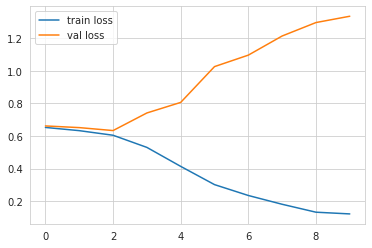

In [33]:
sns.set_style('whitegrid')
sns.lineplot(data=train_losses, label = 'train loss')
sns.lineplot(data=val_losses, label = 'val loss')
plt.savefig('/content/gdrive/MyDrive/Fin-418-NLFF/lstm_loss_plot.png')
plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.load_state_dict(
    torch.load('/content/gdrive/MyDrive/Fin-418-NLFF/models/w_ARIMA/BERT_ft_epoch10.model',
    map_location=torch.device('cuda'))
)

<All keys matched successfully>

In [ ]:
_, prediction, true_values = evaluate(dataloader_val)

In [ ]:
accuracy_per_class(prediction, true_values)

Class: decrease
Accuracy: 2/54

Class: not relevant
Accuracy: 500/506

Class: increase
Accuracy: 6/62

